In [1]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
# from collections import Counter
# from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

/home/leobrasileo/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#!wget 'https://raw.githubusercontent.com/LeoBrasileo/Aprendizaje-Automatico-TP2/refs/heads/main/py/funciones_dataset.py'
#!wget 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/py/marquez_clean.py'
#!wget 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/py/token_embeddings.py'

In [3]:
from funciones_dataset import ETIQUETAS_PUNT_INICIAL, ETIQUETAS_PUNT_FINAL, ETIQUETAS_CAPITALIZACION

#### Ejemplos con BertTokenizer

In [4]:
url = 'https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/data/datos_google_argento.csv'
df_google_arg = pd.read_csv(url, sep=',', index_col=False)
df_google_arg.head()

,texto_original,texto_limpio
0,"Para la caída del cabello, tengo un nuevo champú",para la caída del cabello tengo un nuevo champú
1,Los hámsters comen zanahorias,los hámsters comen zanahorias
2,¿Me podés mandar fotos de la pileta?,me podés mandar fotos de la pileta
3,Hola Cristina que bueno que pueda hablar con vos,hola cristina que bueno que pueda hablar con vos
4,Tranquilo va a estar todo bien,tranquilo va a estar todo bien


Declaramos a nuestro tokenizer como el tokenizer de Bert

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Defino el tamaño del vocabulario como el tamaño del vocabulario default de bert-base-multilingual-cased,
# Esto se usaría en las capas de embeddings, como dimensión. 
VOCAB_SIZE = tokenizer.vocab_size

In [6]:
original = '¿A qué hora vamos a McDonalds?'
texto = "a qué hora vamos a mcdonalds"
tokens = tokenizer.tokenize(texto)
tokens_orig = tokenizer.tokenize(original)

print(tokens)
print(tokens_orig)

['a', 'qué', 'hora', 'va', '##mos', 'a', 'm', '##c', '##dona', '##ld', '##s']
['¿', 'A', 'qué', 'hora', 'va', '##mos', 'a', 'McDonald', '##s', '?']


In [7]:
print(tokenizer.convert_tokens_to_ids(tokens))

[169, 38188, 24301, 10321, 13386, 169, 181, 10350, 64674, 12620, 10107]


### Limpieza de strings

In [5]:
vocales_con_acento_min = [chr(x) for x in [ord('á'), ord('é'), ord('í'), ord('ó'), ord('ú')]]
vocales_con_acento_may = [chr(x) for x in [ord('Á'), ord('É'), ord('Í'), ord('Ó'), ord('Ú')]]
allowed_characters = [chr(x) for x in range(97,123)] + vocales_con_acento_min + [chr(241)] + [chr(10), chr(32)] + [chr(x) for x in range(48,58)] # los caracteres de letras minúsculas, espacio en blanco y fin de linea y números
characters_to_replace = [chr(x) for x in range(65,91)] + vocales_con_acento_may + [chr(209)] #las mayúsculas
characters_to_replace_with = [chr(x) for x in range(97,123)] + vocales_con_acento_min + [chr(241)] #las minúsculas
replace_dict = dict(zip(characters_to_replace, characters_to_replace_with))

def limpiar_string (s) :
  res = ""
  for c in s :
    if c in allowed_characters :
      res += c
    elif c in characters_to_replace :
      res += replace_dict[c]
  return res

In [9]:
test_limpieza = "Veamos que pasa si cortamos un árbol ¿Será capaz de entender? El Árbol no sentirá el corte hasta que sea demaisado tarde: al buscar sus raices para nutrir las hojas, sentirá la desesperación de la falta." + '\n' + '¡Ósado el talador, que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero!'
print(test_limpieza)
print('\n')
print(limpiar_string(test_limpieza))

Veamos que pasa si cortamos un árbol ¿Será capaz de entender? El Árbol no sentirá el corte hasta que sea demaisado tarde: al buscar sus raices para nutrir las hojas, sentirá la desesperación de la falta.
¡Ósado el talador, que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero!


veamos que pasa si cortamos un árbol será capaz de entender el árbol no sentirá el corte hasta que sea demaisado tarde al buscar sus raices para nutrir las hojas sentirá la desesperación de la falta
ósado el talador que se preocupa más por el calor de su morada que la protección que ofrece el bosque y la protección de todas sus criaturas contra el silencio verdadero


### Etiquetas para datos de entrada

**Nota**: es un planteo preliminar, imitando cómo nos piden entregar las respuestas, se pueden hacer modificaciones para lo que necesitemos como entrada

In [6]:
import pandas as pd
from funciones_dataset import asignar_etiquetas_puntuacion, asignar_puntuacion_a_tokens, reconstruir_texto

##### Ejemplo 1:

Primero definimos puntuación para los tokens

Este ejemplo, usando el - , no anda

In [11]:
texto_original = "¿Cuándo vamos a McDonald's?Ellos no vienen. Entonces, - ¿dónde están?"

texto_limpio = limpiar_string(texto_original)
tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original,
                                                instancia_id=1,
                                                instancia_tokens=tokens_texto_limpio)
pd.DataFrame.from_dict(puntuacion_tokens)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,¿,
1,1,##ánd,101439,1,,
2,1,##o,10133,1,,
3,1,va,10321,0,,
4,1,##mos,13386,0,,
5,1,a,169,0,,
6,1,m,181,2,,
7,1,##c,10350,2,,
8,1,##dona,64674,2,,
9,1,##ld,12620,2,,


La instancia etiquetada final (con las etiquetas definidas en _ETIQUETA_PUNT_FINAL_ y _ETIQUETA_PUNT_INICIAL_) sería de esta forma:

In [12]:
tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)
pd.DataFrame.from_dict(tokens_etiquetados)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,1,0
1,1,##ánd,101439,1,0,0
2,1,##o,10133,1,0,0
3,1,va,10321,0,0,0
4,1,##mos,13386,0,0,0
5,1,a,169,0,0,0
6,1,m,181,2,0,0
7,1,##c,10350,2,0,0
8,1,##dona,64674,2,0,0
9,1,##ld,12620,2,0,0


##### Ejemplo 2:

Este ejemplo anda, eliminando el -. 

In [13]:
texto_original = "¿Cuándo vamos a McDonald's? Ellos no vienen. Entonces, ¿dónde están?"

texto_limpio = limpiar_string(texto_original)
tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original,
                                                instancia_id=1,
                                                instancia_tokens=tokens_texto_limpio)

tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)

pd.DataFrame.from_dict(tokens_etiquetados)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,cu,10854,1,1,0
1,1,##ánd,101439,1,0,0
2,1,##o,10133,1,0,0
3,1,va,10321,0,0,0
4,1,##mos,13386,0,0,0
5,1,a,169,0,0,0
6,1,m,181,2,0,0
7,1,##c,10350,2,0,0
8,1,##dona,64674,2,0,0
9,1,##ld,12620,2,0,0


##### Ejemplo 3:

In [14]:
tokens_test_limpieza = tokenizer.tokenize(limpiar_string(test_limpieza))

puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=test_limpieza,
                                                instancia_id=1,
                                                instancia_tokens=tokens_test_limpieza)

tokens_etiquetados = asignar_etiquetas_puntuacion(puntuacion_tokens)

pd.DataFrame.from_dict(tokens_etiquetados).head(12)

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,ve,10323,1,0,0
1,1,##amos,73983,1,0,0
2,1,que,10121,0,0,0
3,1,pasa,26088,0,0,0
4,1,si,10294,0,0,0
5,1,corta,53134,0,0,0
6,1,##mos,13386,0,0,0
7,1,un,10119,0,0,0
8,1,árbol,55220,0,0,0
9,1,será,23843,1,1,0


# Clase del dataset de 100 Años de Soledad


In [7]:
#creaar DataFrame para alimentar el dataset (pensando en que va a ser mas rapido para el entrenamiento)
data_path ='https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2/raw/refs/heads/main/data/marquez_cleaned.csv'  # Remove the leading slash
data = pd.read_csv(data_path, delimiter=',')
texto_original = data['texto_original'].tolist()
# texto_limpio = data['texto_limpio'].tolist()

puntuacion_tokens_marquez = []
problematic_sentences = []

for i in range(4,len(texto_original)):
    try:
        # tokens_texto_original = tokenizer.tokenize(texto_original[i])
        texto_limpio = limpiar_string(texto_original[i])
        tokens_texto_limpio = tokenizer.tokenize(texto_limpio)

        puntuacion_tokens = asignar_puntuacion_a_tokens(instancia_original=texto_original[i],
                                                        instancia_id=i+1,
                                                        instancia_tokens=tokens_texto_limpio)
        puntuacion_tokens = asignar_etiquetas_puntuacion(puntuacion_tokens)
        puntuacion_tokens_marquez.append(puntuacion_tokens)
    except Exception as e:
        # Store problematic sentence info instead of breaking
        problematic_sentences.append({
            'index': i,
            'original_text': texto_original[i],
            'cleaned_text': texto_limpio if 'texto_limpio' in locals() else None,
            'error': str(e)
        })
        continue


print(f"funcionaron: {len(puntuacion_tokens_marquez)} sentences")
print(f"con problemas: {len(problematic_sentences)}")

# oraciones con problemas
for prob in problematic_sentences[:5]:  # Show first 5 problematic sentences
    print(f"Index {prob['index']}: {repr(prob['original_text'][:100])}... Error: {prob['error']}")


# renumerar para que los ids de instancia sean consecutivos
puntuacion_tokens_marquez_clean = []
for new_id, tokens_list in enumerate(puntuacion_tokens_marquez):
    tokens_list_updated = []
    for token_dict in tokens_list:
        token_dict_updated = token_dict.copy()
        token_dict_updated['instancia_id'] = new_id + 1  # que empiece en 1?
        tokens_list_updated.append(token_dict_updated)
    puntuacion_tokens_marquez_clean.append(tokens_list_updated)


funcionaron: 1810 sentences
con problemas: 336
Index 19: 'Si has de volverte loco, vuélvete tú solo gritó . Pero no trates de inculcar a los niños tus ideas d'... Error: string index out of range
Index 28: 'Es el olor del demonio dijo ella. En absoluto corrigió Valeria . Está comprobado que el demonio tien'... Error: string index out of range
Index 36: 'En el mundo están ocurriendo cosas increíbles le decía a Gabriel . Ahí mismo, al otro lado del río, '... Error: string index out of range
Index 51: 'No importa decía Vega . Lo esencial es no perder la orientación.'... Error: string index out of range
Index 58: 'Sus sueños terminaban frente a ese mar color de ceniza, espumoso y sucio, que no merecía los riesgos'... Error: string index out of range


In [8]:
from marquez_clean import MarquezDataset, marquez_collate_fn

dataset_marquez = MarquezDataset(data=puntuacion_tokens_marquez)
loader = DataLoader(dataset_marquez, batch_size=32, shuffle=True, collate_fn=marquez_collate_fn)

# Modelos

## Modelo clásico

Vamos a usar un Random Forest, no necesitamos la clase Dataset para esto porque solo queremos hacer una simple ingenieria de atributos.

Como el Random Forest no puede entender los contextos de la secuencialidad.
Lo que hacemos es aplanar los tokens del dataset y guardar atributos especiales para captar algunos patrones, como si un token es inicial, etc.
Por otro lado ahora el RF entiende de contexto a partir de una ventana parametrizable de los tokens anteriores y posteriores.

In [9]:
from modelos.RF_Global import RF_Global

# armo un dataset flat de 100 años de soledad
puntuacion_marquez_flat = [token for sentence in puntuacion_tokens_marquez_clean for token in sentence]
pd.DataFrame(puntuacion_marquez_flat).head()

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,1,ad,10840,1,0,0
1,1,##rián,93508,1,0,0
2,1,i,177,3,0,0
3,1,gu,75980,0,0,0
4,1,##aran,24367,0,0,3


Separo los datos, entreno el modelo y veamos como fue

In [25]:
train_data, val_data = train_test_split(
    puntuacion_marquez_flat, 
    test_size=0.21,
    shuffle= False #importante que no mezcle para este modelo porque sino despues no puedo rearmar el texto correctamente
)

In [27]:
modelo = RF_Global(window_size=1)

modelo.fit(train_data)

In [28]:
caps_pred, punt_inic_pred, punt_fin_pred = modelo.predict(val_data)
frases_reconstruidas = reconstruir_texto(val_data, caps_pred, punt_inic_pred, punt_fin_pred)

for frase in frases_reconstruidas[:10]:
    print(frase)

Ciento veinte kilos que llegó a tener en la época en que lo desafió la Elefanta se habían reducido a setenta, y ocho la candorosa y abotagada cara de tortuga se le había vuelto de iguana y siempre andaba cerca del aburrimiento, y el cansancio para claudia Sin embargo nunca fue mejor hombre que entonces tal vez porque confundía con el amor la compasión que él le inspiraba y el sentimiento de solidaridad que en ambos había despertado la miseria la cama desmantelada dejó de ser lugar de desafueros y se convirtió en refugio de confidencias
Liberados de los espejos repetidores que habían rematado para comprar animales de rifa y de los damascos y terciopelos concupiscentes que se había comido la muía se quedaban despiertos hasta muy tarde con la inocencia de dos abuelos desvelados aprovechando para sacar cuentas y trasponer centavos el tiempo que antes malgastaban en malgastarse a veces los sorprendían los primeros gallos haciendo y deshaciendo montoncitos de monedas quitando un poco de aquí

In [29]:
print(modelo.score(val_data))

(0.3134568896051571, None, 0.05263157894736842)


Evidentemente aprendio que las oraciones arrancan en mayuscula. Y no hay sufuciente informacion para aprender sobre puntuacion incial (mal dataset)

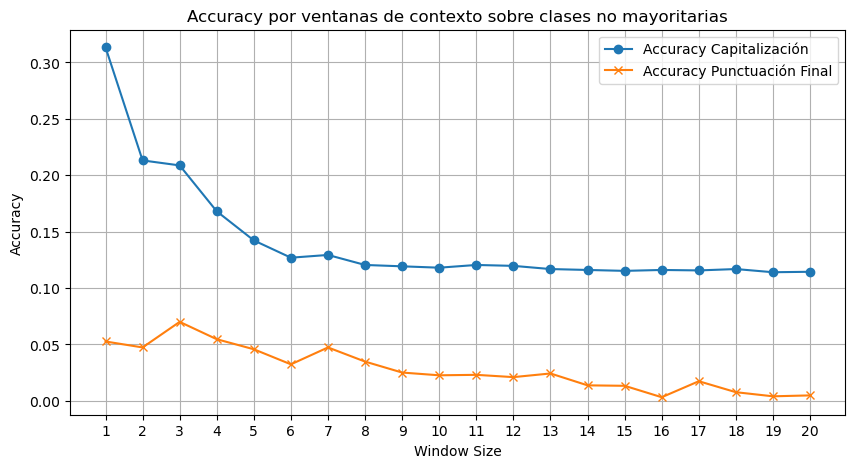

In [30]:
scores_caps = []
#scores_punt_inic = [] #no hay asi que ni las uso
scores_punt_fin = []

windows = 20

for window_size in range(1, windows + 1):
    modelo = RF_Global(window_size=window_size)
    modelo.fit(train_data)
    score_caps, _, score_punt_fin = modelo.score(val_data)
    
    scores_caps.append(score_caps)
    scores_punt_fin.append(score_punt_fin)

plt.figure(figsize=(10, 5))
plt.plot(range(1, windows + 1), scores_caps, label='Accuracy Capitalización', marker='o')
plt.plot(range(1, windows + 1), scores_punt_fin, label='Accuracy Punctuación Final', marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy por ventanas de contexto sobre clases no mayoritarias')
plt.xticks(range(1, windows + 1))
plt.legend()
plt.grid()
plt.show()

## RNN Clásica y Bidireccional

In [21]:
from modelos.RNN_Clasica import RNN_Clasica
from modelos.RNN_Bidireccional import RNN_Bidireccional

# Definición de modelos y entrenamiento

### Definición de modelos e hiperparámetros

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'xpu:0' if torch.xpu.is_available() else device # placa intel

NUM_EPOCHS = 80
LEARNING_RATE = 0.0001
EMBEDDING_DIM = 265         # De ejemplo, por ahora hasta que entrenemos la capa de embeddings. También se pueden probar distintos para c/ modelo.

In [23]:
modelo_bidireccional = RNN_Bidireccional(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, input_size = 3, hidden_size = 700, num_layers=3, punct_class_size=8, cap_class_size=4).to(device)

print(f"Modelo de red neuronal bidireccional creado con {sum(p.numel() for p in modelo_bidireccional.parameters())} parámetros")

Modelo de red neuronal bidireccional creado con 15707312 parámetros


In [24]:
modelo_unidireccional = RNN_Clasica(hidden_size=700, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM).to(device)
optimizer_unidireccional = torch.optim.Adam(modelo_unidireccional.parameters(), lr=LEARNING_RATE)
criterion_unidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal unidireccional creado con {sum(p.numel() for p in modelo_unidireccional.parameters())} parámetros")

Modelo de red neuronal unidireccional creado con 38320165 parámetros


### Entrenamiento

In [25]:
from funciones_redes import ejecutar_epoch_entrenamiento, evaluar_modelo, entrenar_modelo

##### Ejemplo de juguete con 10 samples

Siguiendo la idea de Luciano en clase de entrenar con muchas epochs y pocos samples, para ver si la red logra memorizarlos. Principalmente lo dejo para que lo usemos para verificar que las funciones se ejecutan bien (en este caso en particular, usando la RNN clásica, pero se puede usar en otro momento para cuando haya cambios en las redes)

In [26]:
# Tomamos 10 samples del dataset de Gabriel García Marquez
dataset_marquez_reduced = MarquezDataset(data=puntuacion_tokens_marquez[:10])

# DataLoader con batches de tamaño 1 (dado que son solo 10 samples, pero también se podría hacer 1 solo batch de 10 secuencias, 2 batches de 5 secuencias, o tomar más samples)
loader = DataLoader(dataset_marquez_reduced, batch_size=1, shuffle=True, collate_fn=marquez_collate_fn)

In [27]:
loader = DataLoader(dataset_marquez_reduced, batch_size=1, shuffle=True, collate_fn=marquez_collate_fn)

_ , _ = entrenar_modelo(modelo_unidireccional, loader, loader, optimizer_unidireccional, criterion_unidireccional, cant_epochs=200, device=device)

Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Target puntuación inicial:    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Predicción puntuac

### Prueba con dataset Marquez (65/35) y curva de aprendizaje

Dataset completo: 1810 sentences
Entrenamiento: 1176 sentences (65.0%)
Validación: 634 sentences (35.0%)
Iniciando entrenamiento...
--------------------------------------------------
Predicción puntuación inicial: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

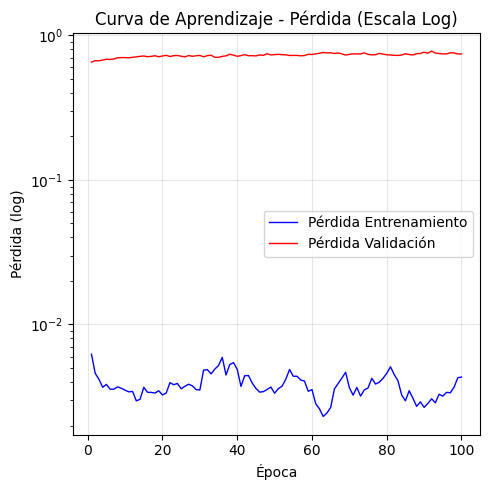


Resultados finales:
Pérdida final de entrenamiento: 0.0043
Pérdida final de validación: 0.7441
Mejor pérdida de validación: 0.6535 (época 1)


In [ ]:
# Crear dataset para Marquez dataset completo

# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    puntuacion_tokens_marquez, 
    test_size=0.35, 
    random_state=42
)

print(f"Dataset completo: {len(puntuacion_tokens_marquez)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(puntuacion_tokens_marquez)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(puntuacion_tokens_marquez)*100:.1f}%)")

# datasets
dataset_train = MarquezDataset(data=train_data)
dataset_val = MarquezDataset(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=marquez_collate_fn)
loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=marquez_collate_fn)


train_losses, val_losses = entrenar_modelo(modelo_unidireccional, loader_train, loader_val, 
                                         optimizer_unidireccional, criterion_unidireccional, cant_epochs=100)
# Curva de aprendizaje
plt.figure(figsize=(5, 5))
epochs = range(1, len(train_losses) + 1)
plt.semilogy(epochs, train_losses, 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs, val_losses, 'r-', label='Pérdida Validación', linewidth=1)
plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")
